# Content
* [1. Renrendai loans](#1)
   * [1.1 Data Summary](#1.1)
   * [1.2 Feature cleanning and engenering](#1.2)
       * [1.2.1 On Default regression](#1.2.1)
       * [1.2.2 On Bids regression](#1.2.2)
   * [1.3 Logit regression](#1.3)
   * [1.4 Ols Regression](#1.4)
* [2. P2P lending platform](#2)
   * [2.1 Datasummary](#2.1)
   * [2.2 Cox Model](#2.2)

<a id="1"></a>
## 1.Renrendai loans

<a id="1.1"></a>
##  1.1 Data Summary

In this part we overlook all the data in "Renrendai".   
(1) We found there are total 10k records X 25 features.  
Most of the features contained clean data except serval features contain incomplete data  
 (
    EDUCATION    9996 non-null   float64  
    WORKTIME     9994 non-null   float64  
    INCOME       9998 non-null   float64  
    IND          9318 non-null   object  
    CITY         9857 non-null   object   
    PURPOSE  9994 non -null       object
 )  
 
 (2) There are 10 features are objects including: STATUS, IND-Industry, City, Purpose, Marry, Open time, Readytime, Title  
 Description, nickname  
 2.1) I transform time value from time to integer for further study,only keeping duration(Ready time -Open time)
 2.2) Create dummy variables for Lable feature with few types including: Marry, Purpose, IND

In [134]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [65]:
data = pd.read_csv(r"..\Week 2 Assignment\loanraw.csv",encoding="gbk")
data.head()

,loanId,STATUS,BIDS,DEFAULT,AMOUNT,INTEREST,MONTHS,CREDIT,HOUSE,CAR,...,IND,CITY,PURPOSE,MARRY,AGE,opentime,readytime,title,description,nickName
0,2,CLOSED,9,0,3000,5.0,6,7,1,1,...,IT,北京,其他借款,未婚,33,2010/10/12 17:17,2010/10/15 11:00,庆祝上线,"看着人人贷经过精心的筹备,和长时间的内测,终于正式和大家见面了.特地来发个标, 希望大家多多...",一夫
1,11,CLOSED,8,0,3000,18.0,3,3,0,0,...,教育/培训,北京,其他借款,未婚,37,2010/10/18 16:40,2010/10/21 17:07,增加信用，重新发布借款,第一次借款不幸失败，这次特意做了收入审核。希望之前支持的朋友继续支持我，新朋友也可以看看我做...,郭遐
2,16,CLOSED,8,0,3000,12.0,12,3,0,0,...,教育/培训,北京,其他借款,未婚,37,2010/10/21 17:26,2010/10/28 14:35,积累信用，继续发标,做过收入认证果然不一样，第一次发标失败了，第二次做了收入认证很快就满标了。 这次降低一点利率...,郭遐
3,19,CLOSED,11,0,3000,8.8,12,7,1,1,...,IT,北京,其他借款,未婚,33,2010/10/25 17:19,2010/10/28 20:58,信用与人人贷一起进步,刚才提前还清了第一笔借款，以证明自己的信用。再次发标只为继续积累信用和人气。希望朋友们投标。...,一夫
4,20,CLOSED,15,0,5000,15.0,12,7,0,1,...,其它,北京,个人消费,未婚,33,2010/10/26 14:29,2010/10/28 14:34,刚刚搬出来自己住，借钱添置些东西,工作也有两年多了，打算自己搬出来住了. 房子已经租好了，跟一个朋友合住，我一个月出1200....,小猫Mia


In [66]:
data.shape

(10000, 25)

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   loanId       10000 non-null  int64  
 1   STATUS       10000 non-null  object 
 2   BIDS         10000 non-null  int64  
 3   DEFAULT      10000 non-null  int64  
 4   AMOUNT       10000 non-null  int64  
 5   INTEREST     10000 non-null  float64
 6   MONTHS       10000 non-null  int64  
 7   CREDIT       10000 non-null  int64  
 8   HOUSE        10000 non-null  int64  
 9   CAR          10000 non-null  int64  
 10  HOUSE_L      10000 non-null  int64  
 11  CAR_L        10000 non-null  int64  
 12  EDUCATION    9996 non-null   float64
 13  WORKTIME     9994 non-null   float64
 14  INCOME       9998 non-null   float64
 15  IND          9318 non-null   object 
 16  CITY         9857 non-null   object 
 17  PURPOSE      9994 non-null   object 
 18  MARRY        10000 non-null  object 
 19  AGE  

### Construct new feature "duration" 
based on the gap between "readytime" and "opentime" (accurate to hour), using day as unit

In [68]:
data['duration'] = (pd.to_datetime(data["readytime"]) - pd.to_datetime(data["opentime"])).astype('timedelta64[h]').astype(float)/24
data.describe()['duration']

count    10000.000000
mean         3.769125
std          4.548706
min         -0.500000
25%          0.000000
50%          2.625000
75%          5.708333
max         37.375000
Name: duration, dtype: float64

### Construct new dummy variables for label features 
MARRY: 4 possible status
PURPOSE: 10 possible status
IND : 20 possible status

In [69]:
data_2 = pd.get_dummies(data,columns=["MARRY","PURPOSE","IND"])

In [70]:
data_2.columns

Index(['loanId', 'STATUS', 'BIDS', 'DEFAULT', 'AMOUNT', 'INTEREST', 'MONTHS',
       'CREDIT', 'HOUSE', 'CAR', 'HOUSE_L', 'CAR_L', 'EDUCATION', 'WORKTIME',
       'INCOME', 'CITY', 'AGE', 'opentime', 'readytime', 'title',
       'description', 'nickName', 'duration', 'MARRY_丧偶', 'MARRY_已婚',
       'MARRY_未婚', 'MARRY_离异', 'PURPOSE_个人消费', 'PURPOSE_其他借款', 'PURPOSE_医疗支出',
       'PURPOSE_婚礼筹备', 'PURPOSE_投资创业', 'PURPOSE_教育培训', 'PURPOSE_短期周转',
       'PURPOSE_装修借款', 'PURPOSE_购房借款', 'PURPOSE_购车借款', 'IND_IT', 'IND_交通运输业',
       'IND_体育/艺术', 'IND_公共事业', 'IND_公益组织', 'IND_其它', 'IND_农业', 'IND_制造业',
       'IND_医疗/卫生/保健', 'IND_娱乐服务业', 'IND_媒体/广告', 'IND_建筑工程', 'IND_房地产业',
       'IND_政府机关', 'IND_教育/培训', 'IND_能源业', 'IND_计算机系统', 'IND_金融/法律',
       'IND_零售/批发', 'IND_餐饮/旅馆业'],
      dtype='object')

### Data summary based on experience
Bowrrer characteristics: Credit, car, house, education, worktime, Income   
Loan characteristics: Amount, interest,MONTHS, duration

In [144]:
data_2.describe()[["CREDIT","CAR","HOUSE","EDUCATION","INCOME","WORKTIME"]]

,CREDIT,CAR,HOUSE,EDUCATION,INCOME,WORKTIME
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.14630,0.391700,0.564500,2.165900,4.309100,2.838100
std,1.53099,0.488155,0.495847,0.817951,1.335715,0.992465
min,1.00000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,1.00000,0.000000,0.000000,2.000000,3.000000,2.000000
50%,2.00000,0.000000,1.000000,2.000000,4.000000,3.000000
75%,3.00000,1.000000,1.000000,3.000000,5.000000,4.000000
max,7.00000,1.000000,1.000000,4.000000,7.000000,4.000000


In [72]:
data_2.describe()[["AMOUNT","INTEREST","MONTHS","duration"]]

,AMOUNT,INTEREST,MONTHS,duration
count,10000.000000,10000.000000,10000.00000,10000.000000
mean,24545.835000,12.621900,12.23730,3.769125
std,38280.756524,2.273689,8.09109,4.548706
min,3000.000000,5.000000,3.00000,-0.500000
25%,8000.000000,11.000000,6.00000,0.000000
50%,14400.000000,12.000000,12.00000,2.625000
75%,26000.000000,13.000000,12.00000,5.708333
max,500000.000000,24.400000,36.00000,37.375000


<a id="1.2"></a>
## 1.2 Feature cleaning and engineering
1. Key Variables for Default regression
2. Key variables for Bids regression

<a id="1.2.1"></a>
### 1.2.1 On Default regression
(1) Based on the result, I just take the four features ahead of loanId.  
(EDUCATION feature needs to be clean up: Because the number of missing records is small and variance is small and it belongs to discrete feature. I simply use median to fill the null value)  

There are no missing records in BIDS

In [73]:
data_2["DEFAULT"].value_counts()

0    8487
1    1513
Name: DEFAULT, dtype: int64

### Correlatin test
Based on the result, I pick 

In [74]:
abs(data_2.corr()["DEFAULT"]).sort_values(ascending=False)[0:11]

DEFAULT         1.000000
CREDIT          0.292815
MONTHS          0.274555
EDUCATION       0.154944
CAR             0.095841
loanId          0.094200
INTEREST        0.082417
MARRY_离异        0.080191
PURPOSE_装修借款    0.072103
HOUSE_L         0.070177
PURPOSE_购车借款    0.059450
Name: DEFAULT, dtype: float64

In [75]:
data_2.describe()[["CREDIT","MONTHS","EDUCATION","CAR"]]

,CREDIT,MONTHS,EDUCATION,CAR
count,10000.00000,10000.00000,9996.000000,10000.000000
mean,2.14630,12.23730,2.165966,0.391700
std,1.53099,8.09109,0.818108,0.488155
min,1.00000,3.00000,1.000000,0.000000
25%,1.00000,6.00000,2.000000,0.000000
50%,2.00000,12.00000,2.000000,0.000000
75%,3.00000,12.00000,3.000000,1.000000
max,7.00000,36.00000,4.000000,1.000000


#### Filling null value in EDUCATION feature 

In [76]:
data_2["EDUCATION"][data_2["EDUCATION"].isnull()] = data_2["EDUCATION"].median()

<ipython-input-76-2bafad20e43f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2["EDUCATION"][data_2["EDUCATION"].isnull()] = data_2["EDUCATION"].median()


In [77]:
data_2.describe()[["CREDIT","MONTHS","EDUCATION","CAR"]]

,CREDIT,MONTHS,EDUCATION,CAR
count,10000.00000,10000.00000,10000.000000,10000.000000
mean,2.14630,12.23730,2.165900,0.391700
std,1.53099,8.09109,0.817951,0.488155
min,1.00000,3.00000,1.000000,0.000000
25%,1.00000,6.00000,2.000000,0.000000
50%,2.00000,12.00000,2.000000,0.000000
75%,3.00000,12.00000,3.000000,1.000000
max,7.00000,36.00000,4.000000,1.000000


<a id="1.2.2"></a>
### 1.2.2 On Bids regression
1.Based on the correlation test result, I found there are far more features are highly relevant to BIDS  
I select features ranking high from highest AMOUNT to INTEREST  
There are few missing records in INCOME and WORKTIME. Similar to CAR, I simply use median value to fill the records.

There are no missing records in BIDS

In [82]:
data_2.describe()['BIDS']

count    10000.000000
mean        24.150600
std         41.342608
min          1.000000
25%          9.000000
50%         15.000000
75%         24.000000
max        592.000000
Name: BIDS, dtype: float64

In [79]:
abs(data_2.corr()["BIDS"]).sort_values(ascending=False)[1:13]

AMOUNT          0.809234
INCOME          0.357055
AGE             0.257725
IND_制造业         0.188173
CAR             0.183072
loanId          0.159011
WORKTIME        0.139645
CREDIT          0.122454
MARRY_已婚        0.122299
MARRY_未婚        0.117044
PURPOSE_其他借款    0.105537
INTEREST        0.097306
Name: BIDS, dtype: float64

In [80]:
bidsIndex = abs(data_2.corr()["BIDS"]).sort_values(ascending=False)[1:13].index
data_2.describe()[bidsIndex]

,AMOUNT,INCOME,AGE,IND_制造业,CAR,loanId,WORKTIME,CREDIT,MARRY_已婚,MARRY_未婚,PURPOSE_其他借款,INTEREST
count,10000.000000,9998.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,9994.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,24545.835000,4.309162,34.755500,0.199700,0.391700,4.188469e+05,2.838003,2.14630,0.638500,0.325200,0.047100,12.621900
std,38280.756524,1.335842,6.682708,0.399795,0.488155,4.464326e+05,0.992755,1.53099,0.480459,0.468473,0.211863,2.273689
min,3000.000000,1.000000,24.000000,0.000000,0.000000,2.000000e+00,1.000000,1.00000,0.000000,0.000000,0.000000,5.000000
25%,8000.000000,3.000000,30.000000,0.000000,0.000000,8.463525e+04,2.000000,1.00000,0.000000,0.000000,0.000000,11.000000
50%,14400.000000,4.000000,33.000000,0.000000,0.000000,3.219450e+05,3.000000,2.00000,1.000000,0.000000,0.000000,12.000000
75%,26000.000000,5.000000,38.000000,0.000000,1.000000,5.829305e+05,4.000000,3.00000,1.000000,1.000000,0.000000,13.000000
max,500000.000000,7.000000,53.000000,1.000000,1.000000,2.086049e+06,4.000000,7.00000,1.000000,1.000000,1.000000,24.400000


#### Filling missing records for INCOME and WORKTIME

In [81]:
data_2["INCOME"][data_2["INCOME"].isnull()] = data_2["INCOME"].median()
data_2["WORKTIME"][data_2["WORKTIME"].isnull()] = data_2["WORKTIME"].median()
data_2.describe()[bidsIndex]

<ipython-input-81-244c4f75e698>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2["INCOME"][data_2["INCOME"].isnull()] = data_2["INCOME"].median()
<ipython-input-81-244c4f75e698>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2["WORKTIME"][data_2["WORKTIME"].isnull()] = data_2["WORKTIME"].median()


,AMOUNT,INCOME,AGE,IND_制造业,CAR,loanId,WORKTIME,CREDIT,MARRY_已婚,MARRY_未婚,PURPOSE_其他借款,INTEREST
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,24545.835000,4.309100,34.755500,0.199700,0.391700,4.188469e+05,2.838100,2.14630,0.638500,0.325200,0.047100,12.621900
std,38280.756524,1.335715,6.682708,0.399795,0.488155,4.464326e+05,0.992465,1.53099,0.480459,0.468473,0.211863,2.273689
min,3000.000000,1.000000,24.000000,0.000000,0.000000,2.000000e+00,1.000000,1.00000,0.000000,0.000000,0.000000,5.000000
25%,8000.000000,3.000000,30.000000,0.000000,0.000000,8.463525e+04,2.000000,1.00000,0.000000,0.000000,0.000000,11.000000
50%,14400.000000,4.000000,33.000000,0.000000,0.000000,3.219450e+05,3.000000,2.00000,1.000000,0.000000,0.000000,12.000000
75%,26000.000000,5.000000,38.000000,0.000000,1.000000,5.829305e+05,4.000000,3.00000,1.000000,1.000000,0.000000,13.000000
max,500000.000000,7.000000,53.000000,1.000000,1.000000,2.086049e+06,4.000000,7.00000,1.000000,1.000000,1.000000,24.400000


#### To illustrate the relationship better we plot the figure
Relationship between BIDS and threee most significant features

Cutting data 

In [133]:
data_2.loc[:,"AMOUNTLABEL"] = pd.cut(data["AMOUNT"],5)
data_2.loc[:,"AGELABEL"] = pd.cut(data["AGE"],3)

In [135]:
data_2["AMOUNTLABEL"].value_counts()
data_2["AGELABEL"].value_counts()

(2503.0, 102400.0]      9732
(102400.0, 201800.0]     186
(201800.0, 301200.0]      63
(400600.0, 500000.0]      11
(301200.0, 400600.0]       8
Name: AMOUNTLABEL, dtype: int64

(23.971, 33.667]    5053
(33.667, 43.333]    3702
(43.333, 53.0]      1245
Name: AGELABEL, dtype: int64

In [137]:
amountLabels = []
for label in data_2["AMOUNTLABEL"].value_counts().index:
    amountLabels.append(str(label))

incomeLabels = [1,2,3,4,5,6,7]
ageLabels = ["23-33","33-43","43-53"]


<Figure size 1008x576 with 0 Axes>

<AxesSubplot:>

Text(0.5, 0, 'AMOUNT')

Text(0, 0.5, 'BIDS')

<AxesSubplot:>

Text(0.5, 0, 'INCOME')

<AxesSubplot:>

Text(0.5, 0, 'AGE')

<function matplotlib.pyplot.show(close=None, block=None)>

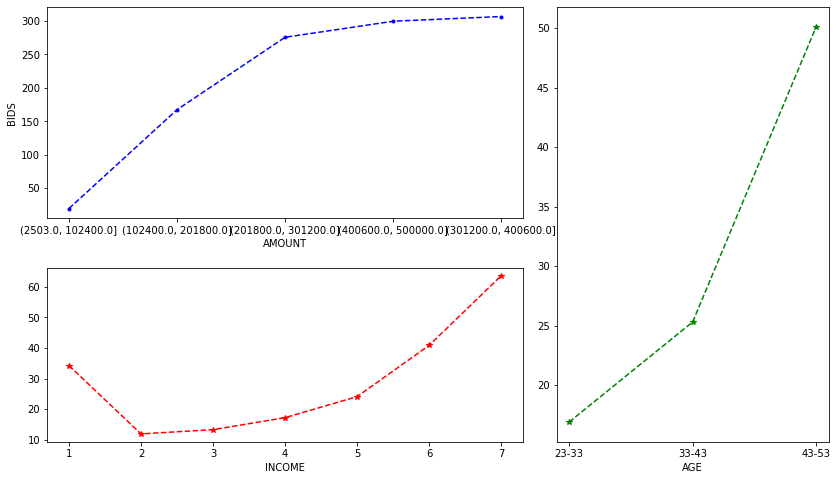

In [143]:
plt.figure(figsize=[14, 8])
grid = plt.GridSpec(12, 8, wspace=0.5, hspace=0.5)
plt.subplot(grid[0:6,0:5])

plt.plot(amountLabels,data_2.groupby(["AMOUNTLABEL"])["BIDS"].mean(),"b--.")

plt.xlabel("AMOUNT")
plt.ylabel("BIDS")

plt.subplot(grid[7:12,0:5])

plt.plot(incomeLabels,data_2.groupby(["INCOME"])["BIDS"].mean(),"r--*")
plt.xlabel("INCOME")


plt.subplot(grid[0:12,5:8])

plt.plot(ageLabels,data_2.groupby(["AGELABEL"])["BIDS"].mean(),"g--*")
plt.xlabel("AGE")
plt.show